In [2]:
#pip install shap


  Obtaining dependency information for shap from https://files.pythonhosted.org/packages/72/28/d4dcf1b06761c916f642e0fe1293ed8081ce32991b32eada2212f639433c/shap-0.47.1-cp311-cp311-win_amd64.whl.metadata
  Obtaining dependency information for slicer==0.0.8 from https://files.pythonhosted.org/packages/63/81/9ef641ff4e12cbcca30e54e72fb0951a2ba195d0cda0ba4100e532d929db/slicer-0.0.8-py3-none-any.whl.metadata
   ---------------------------------------- 0.0/489.8 kB ? eta -:--:--
   ----- ---------------------------------- 61.4/489.8 kB 3.2 MB/s eta 0:00:01
   ----- ---------------------------------- 61.4/489.8 kB 3.2 MB/s eta 0:00:01
   ----- ---------------------------------- 61.4/489.8 kB 3.2 MB/s eta 0:00:01
   ----- ---------------------------------- 61.4/489.8 kB 3.2 MB/s eta 0:00:01
   ----- ---------------------------------- 61.4/489.8 kB 3.2 MB/s eta 0:00:01
   ----- ---------------------------------- 61.4/489.8 kB 3.2 MB/s eta 0:00:01
   ----- ---------------------------------- 61.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import shap
import warnings
import logging

warnings.filterwarnings("ignore")
logger = logging.getLogger('shap')
logger.disabled = True

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import LabelEncoder
import time

### Load the dataset

In [5]:
credit_card_df = pd.read_csv(r"C:\Users\Zaya\OneDrive - Eotvos Lorand Tudomanyegyetem\Dokumentumok\2023 ELTE Study\DSLAB2\data\creditcard.csv")

In [11]:
ae_df = pd.read_csv(r"C:\Users\Zaya\OneDrive - Eotvos Lorand Tudomanyegyetem\Dokumentumok\2023 ELTE Study\DSLAB2\data\prefect_autoencoder_data_top_10k.csv")

In [16]:
kdd_df = pd.read_csv(r"C:\Users\Zaya\OneDrive - Eotvos Lorand Tudomanyegyetem\Dokumentumok\2023 ELTE Study\DSLAB2\data\kddcup99_csv.csv")

In [67]:
df = kdd_df

In [18]:
print("Dataset Shape:", df.shape)

df.head()

Dataset Shape: (494020, 42)


,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal


In [21]:
df['label'].unique()

array(['normal', 'buffer_overflow', 'loadmodule', 'perl', 'neptune',
       'smurf', 'guess_passwd', 'pod', 'teardrop', 'portsweep', 'ipsweep',
       'land', 'ftp_write', 'back', 'imap', 'satan', 'phf', 'nmap',
       'multihop', 'warezmaster', 'warezclient', 'spy', 'rootkit'],
      dtype=object)

In [68]:
filtered_data = df[df['label'].isin(['normal', 'back'])]

# Rename 'normal' as 0 and 'back' as 1
filtered_data['label'] = filtered_data['label'].replace({'normal': 0, 'back': 1})

filtered_data = filtered_data.reset_index(drop=True)

filtered_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0.0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0
1,0.0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
2,0.0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0.0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
4,0.0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


In [69]:
filtered_data.shape

(99480, 42)

In [70]:
filtered_data.dtypes

duration                       float64
protocol_type                   object
service                         object
flag                            object
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
lnum_compromised                 int64
lroot_shell                      int64
lsu_attempted                    int64
lnum_root                        int64
lnum_file_creations              int64
lnum_shells                      int64
lnum_access_files                int64
lnum_outbound_cmds               int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                        int64
serror_rate                    float64
srv_serror_rate          

In [71]:
categorical_columns = filtered_data.select_dtypes(include=['object']).columns

print("Categorical columns:", categorical_columns)

Categorical columns: Index(['protocol_type', 'service', 'flag'], dtype='object')


In [72]:
label_encoder = LabelEncoder()

# Apply Label Encoding to each object (categorical) column
for col in filtered_data.select_dtypes(include=['object']).columns:
    filtered_data[col] = label_encoder.fit_transform(filtered_data[col]).astype(float)

In [73]:
filtered_data = filtered_data.astype(float)
filtered_data['label'] = filtered_data['label'].astype(int)

In [74]:
filtered_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0.0,1.0,10.0,8.0,181.0,5450.0,0.0,0.0,0.0,0.0,...,9.0,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0
1,0.0,1.0,10.0,8.0,239.0,486.0,0.0,0.0,0.0,0.0,...,19.0,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
2,0.0,1.0,10.0,8.0,235.0,1337.0,0.0,0.0,0.0,0.0,...,29.0,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0.0,1.0,10.0,8.0,219.0,1337.0,0.0,0.0,0.0,0.0,...,39.0,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
4,0.0,1.0,10.0,8.0,217.0,2032.0,0.0,0.0,0.0,0.0,...,49.0,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


### Data Normalization

In [75]:
for col in filtered_data.columns[:-1]:
    min_val = filtered_data[col].min()
    max_val = filtered_data[col].max()
    if min_val != max_val:
        filtered_data[col] = (filtered_data[col] - min_val) / (max_val - min_val)

In [76]:
filtered_data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0.0,0.5,0.416667,1.0,0.000082,0.001062,0.0,0.0,0.0,0.0,...,0.035294,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,0
1,0.0,0.5,0.416667,1.0,0.000109,0.000095,0.0,0.0,0.0,0.0,...,0.074510,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0
2,0.0,0.5,0.416667,1.0,0.000107,0.000260,0.0,0.0,0.0,0.0,...,0.113725,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.5,0.416667,1.0,0.000100,0.000260,0.0,0.0,0.0,0.0,...,0.152941,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.5,0.416667,1.0,0.000099,0.000396,0.0,0.0,0.0,0.0,...,0.192157,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,0


### Train and Test Split

In [77]:
X = filtered_data.iloc[:,:-1]
y = filtered_data.iloc[:, -1]

print('x shape:', X.shape)
print('y shape:', y.shape)
print(y.value_counts())

train_idx = y[y==0].index.values
test_idx = y[y==1].index.values

X_train = X.iloc[train_idx]
y_train = y[train_idx]

X_test = X.iloc[test_idx]
y_test = y[test_idx]

x shape: (99480, 41)
y shape: (99480,)
0    97277
1     2203
Name: label, dtype: int64


In [78]:
X_train.loc[[0]]

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0.0,0.5,0.416667,1.0,0.000082,0.001062,0.0,0.0,0.0,0.0,...,0.035294,0.035294,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0


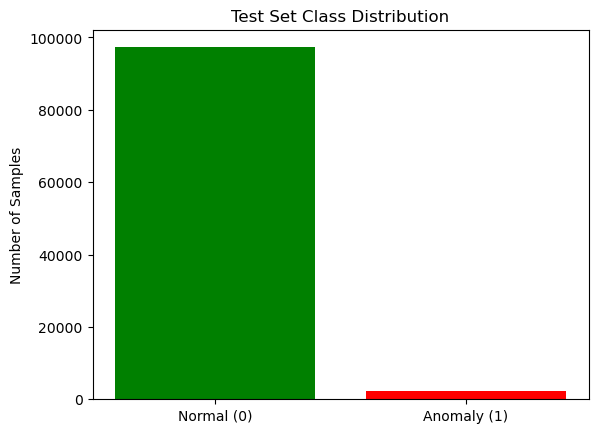

In [79]:
plt.bar(['Normal (0)', 'Anomaly (1)'], y.value_counts(), color=['green', 'red'])
plt.title("Test Set Class Distribution")
plt.ylabel("Number of Samples")
plt.show()

In [80]:
percent_anomaly = (y.value_counts()[1] / len(y)) * 100
print(f"Anomaly percentage: {percent_anomaly:.2f}%")

Anomaly percentage: 2.21%


In [81]:
#Added this section to balance test set for evaluation purpose
X_normal_sampled = X_train[y_train == 0].sample(n=2203, random_state=42)
X_train_remaining = X_train.drop(X_normal_sampled.index)
y_train_remaining = y_train.drop(X_normal_sampled.index)

X_test_balanced = pd.concat([X_normal_sampled, X_test])
y_test_balanced = np.concatenate([np.zeros(2203), np.ones(y_test.shape[0])])

# Convert y_test_balanced to a pandas Series with the same index as X_test_balanced
y_test_balanced = pd.Series(y_test_balanced, index=X_test_balanced.index)

X_train = X_train_remaining
y_train = y_train_remaining

X_test = X_test_balanced
y_test = y_test_balanced


print(y_test.value_counts())

0.0    2203
1.0    2203
dtype: int64


In [82]:
print("Total rows in X_test:", X_test.shape[0])  # Total rows in X_test after sampling
print("Total rows in X_train:", X_train.shape[0])  # Total rows in X_train after sampling
print("Total rows in X_train for normal instances (y == 0):", X_train[y_train == 0].shape[0]) 
print("Total rows in X_train for anomaly instances (y == 1):", X_train[y_train == 1].shape[0])

Total rows in X_test: 4406
Total rows in X_train: 95074
Total rows in X_train for normal instances (y == 0): 95074
Total rows in X_train for anomaly instances (y == 1): 0


### Initializing Class and Parameters

In [19]:
#class ExplainAnomaliesUsingSHAP:
#    autoencoder = None
#    num_anomalies_to_explain = None
#    reconstruction_error_percent = None
#    shap_values_selection = None
#    counter = None

#    def __init__(self, num_anomalies_to_explain=100, reconstruction_error_percent=0.5, shap_values_selection='mean'):
#        self.num_anomalies_to_explain = num_anomalies_to_explain
#        self.reconstruction_error_percent = reconstruction_error_percent
#        self.shap_values_selection = shap_values_selection

In [97]:
import torch
import torch.nn as nn
import torch.optim as optim
import time
from torch.utils.data import DataLoader, TensorDataset

In [103]:
class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim // 4),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(input_dim // 4, input_dim // 2),
            nn.ReLU(),
            nn.Linear(input_dim // 2, input_dim),
            nn.Sigmoid()  # Sigmoid for the output layer to get values in range [0, 1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [104]:
# L1 Regularization Term
def l1_regularization(model, lambda_l1=1e-5):
    l1_norm = 0
    for param in model.parameters():
        l1_norm += torch.sum(torch.abs(param))  # L1 regularization
    return lambda_l1 * l1_norm

In [101]:
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)  # Convert X_train to a tensor
train_dataset = TensorDataset(X_train_tensor, X_train_tensor)  # Input and output are the same
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

### Training the Autoencoder

In [83]:
#Pytorch

# Training loop
start_time = time.time()
best_loss = float('inf')
patience_counter = 0

input_dim = X_train.shape[1]
epochs = 1000
learning_rate = 1e-3
patience = 5  # Early stopping patience

# Initialize model, optimizer, and loss function
model = Autoencoder(input_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
criterion = nn.MSELoss()


for epoch in range(epochs):
    model.train()
    epoch_loss = 0

    for batch_idx, (data, _) in enumerate(train_loader):
        optimizer.zero_grad()
        
        # Forward pass
        reconstructed = model(data)
        
        # Compute the reconstruction loss (MSE)
        loss = criterion(reconstructed, data)
        
        # Apply L1 regularization
        l1_reg = l1_regularization(model)
        
        # Total loss: reconstruction loss + L1 regularization
        total_loss = loss + l1_reg
        
        total_loss.backward()
        optimizer.step()
        
        epoch_loss += total_loss.item()

    # Average loss for this epoch
    epoch_loss /= len(train_loader)
    
    # Early stopping logic
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        patience_counter = 0
    else:
        patience_counter += 1

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

    if epoch % 10 == 0:
        print(f"Epoch [{epoch}/{epochs}], Loss: {epoch_loss:.4f}")

end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time
print(f"Execution Time: {execution_time:.4f} seconds")

NameError: name 'Autoencoder' is not defined

In [84]:
start_time = time.time()

input_dim = X_train.shape[1]

input_layer = Input(shape=(input_dim,))

encoder = Dense(int(input_dim / 2), activation='relu', activity_regularizer=regularizers.l1(10e-7))(input_layer)
encoder = Dense(int(input_dim / 4), activation='relu', kernel_regularizer=regularizers.l2(10e-7))(encoder)

decoder = Dense(int(input_dim / 2), activation='relu', kernel_regularizer=regularizers.l2(10e-7))(encoder)
decoder = Dense(input_dim, activation='sigmoid', kernel_regularizer=regularizers.l2(10e-7))(decoder)

autoencoder = Model(inputs=input_layer, outputs=decoder)

autoencoder.summary()

autoencoder.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])

earlystopper = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
history = autoencoder.fit(X_train, X_train, epochs=1000, batch_size=64, shuffle=True,
                 validation_split=0.1, verbose=2, callbacks=[earlystopper])

end_time = time.time()

# Calculate execution time
execution_time = end_time - start_time

print(f"Execution Time: {execution_time:.4f} seconds")

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 41)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 20)             │           840 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 20)             │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 41)             │           861 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,131 (8.32 KB)

 Trainable params: 2,131 (8.32 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/1000
1337/1337 - 6s - 5ms/step - loss: 0.0249 - mse: 0.0241 - val_loss: 0.0039 - val_mse: 0.0029
Epoch 2/1000
1337/1337 - 3s - 2ms/step - loss: 0.0032 - mse: 0.0023 - val_loss: 0.0020 - val_mse: 0.0013
Epoch 3/1000
1337/1337 - 3s - 2ms/step - loss: 0.0020 - mse: 0.0014 - val_loss: 0.0015 - val_mse: 0.0010
Epoch 4/1000
1337/1337 - 3s - 2ms/step - loss: 0.0015 - mse: 0.0011 - val_loss: 0.0013 - val_mse: 8.5141e-04
Epoch 5/1000
1337/1337 - 3s - 2ms/step - loss: 0.0013 - mse: 8.9534e-04 - val_loss: 0.0012 - val_mse: 7.6257e-04
Epoch 6/1000
1337/1337 - 3s - 2ms/step - loss: 0.0012 - mse: 7.9980e-04 - val_loss: 0.0011 - val_mse: 6.9464e-04
Epoch 7/1000
1337/1337 - 3s - 2ms/step - loss: 0.0011 - mse: 7.1602e-04 - val_loss: 0.0010 - val_mse: 6.3053e-04
Epoch 8/1000
1337/1337 - 3s - 2ms/step - loss: 0.0010 - mse: 6.4079e-04 - val_loss: 9.7254e-04 - val_mse: 5.9537e-04
Epoch 9/1000
1337/1337 - 2s - 2ms/step - loss: 9.5723e-04 - mse: 5.9394e-04 - val_loss: 9.3367e-04 - val_mse: 5.6571e-04

Epoch 69/1000
1337/1337 - 3s - 2ms/step - loss: 5.9219e-04 - mse: 2.9658e-04 - val_loss: 5.6877e-04 - val_mse: 2.7232e-04
Epoch 70/1000
1337/1337 - 3s - 2ms/step - loss: 5.9151e-04 - mse: 2.9590e-04 - val_loss: 5.6358e-04 - val_mse: 2.6673e-04
Epoch 71/1000
1337/1337 - 2s - 2ms/step - loss: 5.9013e-04 - mse: 2.9486e-04 - val_loss: 5.6455e-04 - val_mse: 2.6714e-04
Epoch 72/1000
1337/1337 - 3s - 2ms/step - loss: 5.8872e-04 - mse: 2.9353e-04 - val_loss: 5.6217e-04 - val_mse: 2.6658e-04
Epoch 73/1000
1337/1337 - 2s - 2ms/step - loss: 5.8750e-04 - mse: 2.9220e-04 - val_loss: 5.6264e-04 - val_mse: 2.6569e-04
Epoch 74/1000
1337/1337 - 3s - 2ms/step - loss: 5.8607e-04 - mse: 2.9103e-04 - val_loss: 5.5996e-04 - val_mse: 2.6234e-04
Epoch 75/1000
1337/1337 - 3s - 2ms/step - loss: 5.8484e-04 - mse: 2.8974e-04 - val_loss: 5.5821e-04 - val_mse: 2.6113e-04
Epoch 76/1000
1337/1337 - 3s - 2ms/step - loss: 5.8466e-04 - mse: 2.8972e-04 - val_loss: 5.6000e-04 - val_mse: 2.6287e-04
Epoch 77/1000
1337/1337 

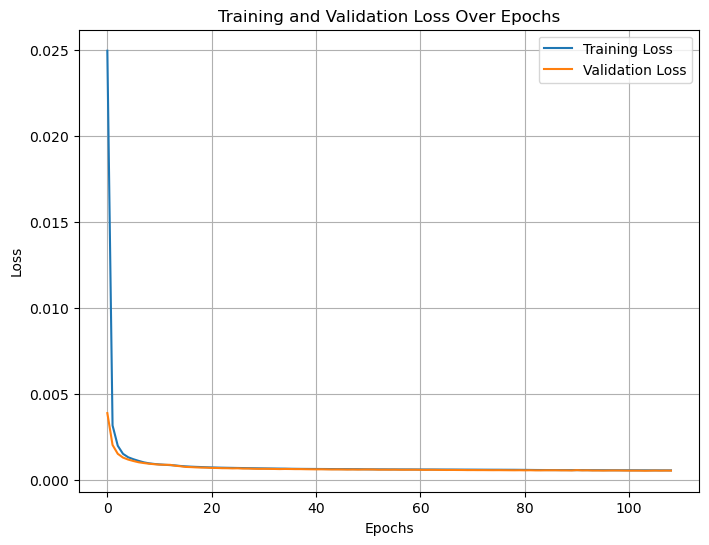

In [85]:
# Plot the training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

### Evaluate the autoencoder for anomaly detection.

In [86]:
X_train_pred = autoencoder.predict(X_train)
X_test_pred = autoencoder.predict(X_test)

train_recon_error = np.mean(np.square(X_train - X_train_pred), axis=1)
test_recon_error = np.mean(np.square(X_test - X_test_pred), axis=1)

threshold = np.percentile(train_recon_error, 95)
y_pred = [1 if e > threshold else 0 for e in test_recon_error]

2972/2972 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
138/138 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


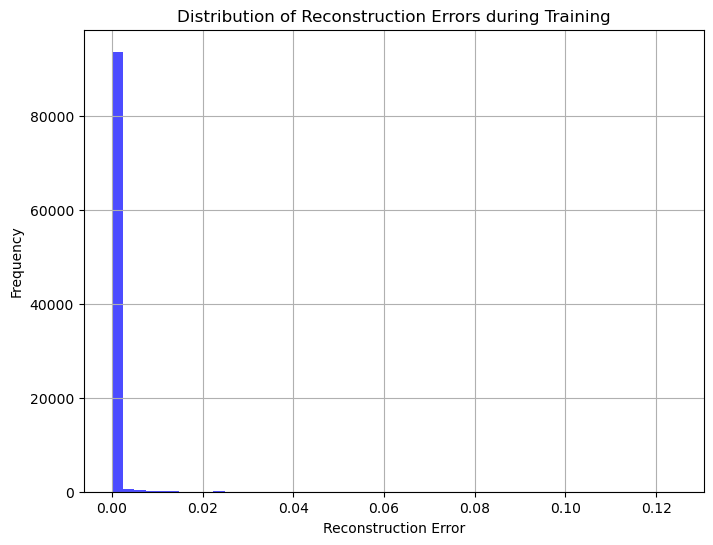

In [87]:
plt.figure(figsize=(8, 6))
plt.hist(train_recon_error, bins=50, alpha=0.7, color='blue')
plt.title('Distribution of Reconstruction Errors during Training')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [88]:
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", conf_matrix)


# Precision, Recall, F1-Score for anomaly detection
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print individual scores
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

# Classification report for a detailed overview
print(classification_report(y_test, y_pred))

Confusion Matrix:
 [[2100  103]
 [1454  749]]
Precision: 0.8791
Recall: 0.3400
F1-Score: 0.4903
              precision    recall  f1-score   support

         0.0       0.59      0.95      0.73      2203
         1.0       0.88      0.34      0.49      2203

    accuracy                           0.65      4406
   macro avg       0.73      0.65      0.61      4406
weighted avg       0.73      0.65      0.61      4406



In [89]:
fpr, tpr, thresholds = roc_curve(y_test, test_recon_error)

# Calculate the AUC score
roc_auc = auc(fpr, tpr)
print(f'AUC: {roc_auc:.4f}')

AUC: 0.9039


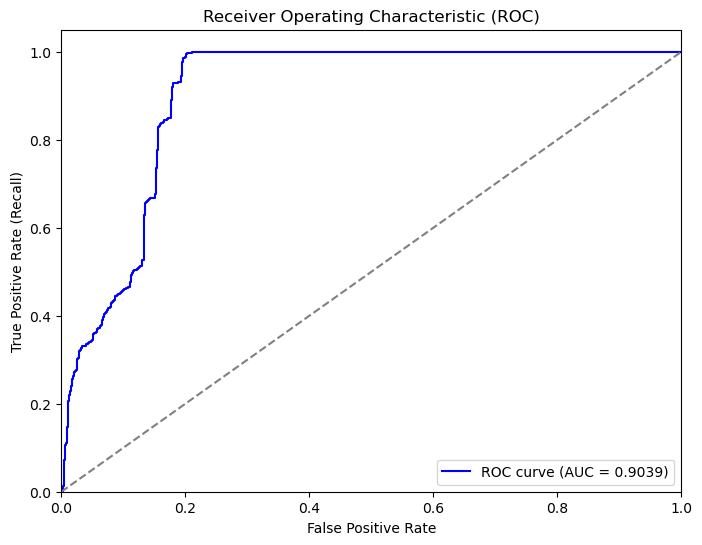

In [90]:
# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='b', label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line (random classifier)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

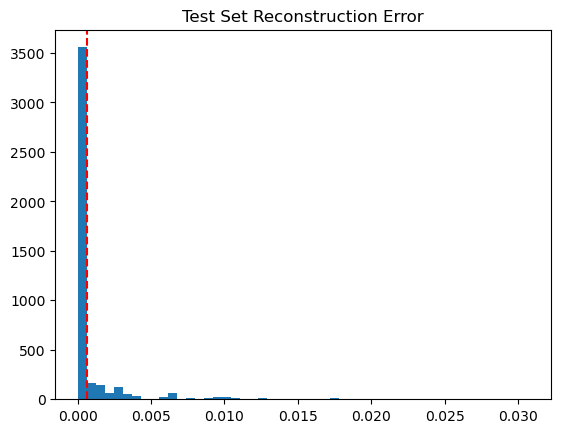

In [91]:
plt.hist(test_recon_error, bins=50)
plt.axvline(threshold, color='red', linestyle='--')
plt.title("Test Set Reconstruction Error")
plt.show()

### Getting Top Anomalies

In [92]:
# Get top 10 anomalies for explanation

#predictions = autoencoder.predict(X_test)
square_errors = np.power(X_test - X_test_pred, 2)
mse_series = pd.Series(np.mean(square_errors, axis=1))

most_anomal_trx = mse_series.sort_values(ascending=False)
columns = ["id", "mse_all_columns"]
columns.extend(["squared_error_" + x for x in list(X_test.columns)])

items = []
for x in most_anomal_trx.iteritems():
    item = [x[0], x[1]]
    item.extend(square_errors.loc[x[0]])
    items.append(item)

df_anomalies = pd.DataFrame(items, columns=columns)
df_anomalies.set_index('id', inplace=True)

top_anomalies_to_explain = df_anomalies.head(10).index  # Heden anomaly explain hiihee songoh

In [93]:
df_anomalies.head(10)

,mse_all_columns,squared_error_duration,squared_error_protocol_type,squared_error_service,squared_error_flag,squared_error_src_bytes,squared_error_dst_bytes,squared_error_land,squared_error_wrong_fragment,squared_error_urgent,...,squared_error_dst_host_count,squared_error_dst_host_srv_count,squared_error_dst_host_same_srv_rate,squared_error_dst_host_diff_srv_rate,squared_error_dst_host_same_src_port_rate,squared_error_dst_host_srv_diff_host_rate,squared_error_dst_host_serror_rate,squared_error_dst_host_srv_serror_rate,squared_error_dst_host_rerror_rate,squared_error_dst_host_srv_rerror_rate
id,,,,,,,,,,,,,,,,,,,,,
62945,0.030714,2.684233e-07,2.120664e-03,4.788750e-03,0.022578,0.000593,8.334905e-07,1.224594e-08,1.134425e-08,1.243108e-08,...,0.006995,0.066742,1.806555e-01,0.021308,1.854175e-04,0.091733,2.740879e-08,5.388643e-06,1.347793e-01,1.718500e-02
58990,0.027410,3.281836e-08,9.655353e-03,2.166861e-03,0.000001,0.998911,4.884697e-07,1.202378e-08,1.115328e-08,1.220230e-08,...,0.001675,0.020988,7.879611e-03,0.000305,1.789658e-02,0.000032,4.482668e-06,1.947774e-06,3.195406e-13,2.276627e-12
62933,0.026650,7.935695e-08,2.297097e-03,2.740890e-03,0.016354,0.000593,8.307814e-07,1.221646e-08,1.131892e-08,1.240070e-08,...,0.001668,0.032772,6.551216e-02,0.027996,1.442420e-07,0.074702,2.538070e-08,9.250571e-06,1.929610e-01,8.305628e-02
71960,0.024932,1.006493e-07,4.369415e-07,9.381962e-07,0.000011,0.998923,5.191290e-07,1.202552e-08,1.115476e-08,1.220409e-08,...,0.000473,0.009913,1.307863e-03,0.001760,7.417701e-03,0.001510,3.226315e-05,3.736015e-05,9.400507e-12,1.383389e-09
90614,0.024663,1.303769e-05,1.071985e-03,3.419411e-03,0.000013,0.998938,4.600484e-07,1.177863e-08,1.094239e-08,1.195003e-08,...,0.000779,0.000465,2.094126e-03,0.000017,2.931290e-03,0.000037,1.532954e-04,2.335005e-05,3.671072e-13,3.587688e-14
18751,0.024503,9.745401e-08,4.544171e-05,3.068944e-04,0.000005,0.000002,5.097899e-07,1.206149e-08,1.118568e-08,1.224113e-08,...,0.000752,0.000007,7.418412e-07,0.001221,1.355727e-03,0.000054,6.821191e-06,1.136539e-05,4.347276e-11,2.694537e-09
39561,0.023939,6.707693e-09,2.680491e-06,7.609131e-03,0.004274,0.000593,8.704627e-07,1.225442e-08,1.135158e-08,1.243983e-08,...,0.061015,0.000601,9.891060e-03,0.000035,6.244500e-06,0.003865,6.328760e-07,3.336802e-07,1.333977e-03,4.465338e-06
62923,0.021212,9.576682e-08,7.836260e-06,1.533802e-03,0.019980,0.000594,8.406888e-07,1.215251e-08,1.126403e-08,1.233485e-08,...,0.000025,0.012245,2.949909e-03,0.018794,4.607720e-04,0.042662,1.128637e-08,1.457034e-05,2.984029e-01,5.879029e-02
35807,0.021002,8.570487e-08,5.957208e-03,9.276875e-04,0.119499,0.000564,5.516644e-07,1.230806e-08,1.139764e-08,1.249507e-08,...,0.003702,0.386542,1.452060e-01,0.001141,3.082444e-05,0.020427,5.053241e-08,2.499440e-07,1.343260e-03,2.024470e-03


In [94]:
df_anomalies.shape

(4406, 42)

In [95]:
top_anomalies_to_explain

Int64Index([62945, 58990, 62933, 71960, 90614, 18751, 39561, 62923, 35807,
            39221],
           dtype='int64', name='id')

### Errors Data Frame per Record

In [96]:
def get_errors_df_per_record(record):
    prediction = autoencoder.predict(np.array([[record]])[0])[0]
    square_errors = np.power(record - prediction, 2)
    errors_df = pd.DataFrame({'col_name': square_errors.index, 'err': square_errors}).reset_index(drop=True)
    total_mse = np.mean(square_errors)
    errors_df.sort_values(by='err', ascending=False, inplace=True)
    return errors_df, total_mse

### Calculating Features with Highest Reconstruction Error

In [97]:
def get_num_features_with_highest_reconstruction_error(total_squared_error, errors_df):
    error = 0
    for num_of_features, index in enumerate(errors_df.index):
        error += errors_df.loc[index, 'err']
        #print("------------Error---------------")
        #print(error)
        if error >= 0.5 * total_squared_error:  # 0.5 is the default reconstruction_error_percent
            break
    return num_of_features + 1

### Predicting Feature Value

In [98]:
def func_predict_feature(record, counter):
    #print("Record in func_predict_feature")
    #print(record)
    #print("Counter in func_predict_feature")
    #print(counter)
    record_prediction = autoencoder.predict(record)[:, counter]
    
    #print("--------------Prediction of top anomaly record------------------")
    #print(record_prediction)
    return record_prediction

#X_test_pred = autoencoder.predict(X_test)

### Creating Background Set for SHAP

In [99]:
background_set = X_train.head(200)  # Get first 200 records (adjust the number as needed)
#background = X_train.sample(200, random_state=0)

### Getting SHAP Values for Features

In [100]:
def get_shap_values(df_top_err, record_to_explain, num_of_features): 
     
    shap_values_all_features = [[] for num in range(num_of_features)]
    
    for i in range(num_of_features):
        #print("---Orig counter---")
        counter = df_top_err.index[i]
        #print(counter)
        explainer = shap.KernelExplainer(lambda x: func_predict_feature(x, counter), background_set)
        shap_values = explainer.shap_values(record_to_explain, nsamples='auto')
        #print("---Shap value---")
        #print(shap_values)
        shap_values_all_features[i] = shap_values
        #print("---shap_values_all_features", i, "---")
        #print(shap_values_all_features[i])

     
    shap_values_all_features = np.fabs(shap_values_all_features)
    #print("---shap_values_all_features---")
    #print(shap_values_all_features)

    return shap_values_all_features

### Getting Highest SHAP Values

In [101]:
def get_highest_shap_values(shap_values_df, shap_values_selection):

        all_explaining_features_df = pd.DataFrame()

        for i in range(shap_values_df.shape[0]):
            shap_values = shap_values_df.iloc[i]

            if shap_values_selection == 'mean':
                treshold_val = np.mean(shap_values)

            elif shap_values_selection == 'median':
                treshold_val = np.median(shap_values)

            elif shap_values_selection == 'constant':
                num_explaining_features = 5
                explaining_features = shap_values_df[i:i + 1].stack().nlargest(num_explaining_features)
                all_explaining_features_df = pd.concat([all_explaining_features_df, explaining_features], axis=0)
                continue

            else:
                raise ValueError('unknown SHAP value selection method')

            num_explaining_features = 0
            for j in range(len(shap_values)):
                if shap_values[j] > treshold_val:
                    num_explaining_features += 1
            explaining_features = shap_values_df[i:i + 1].stack().nlargest(num_explaining_features)
            all_explaining_features_df = pd.concat([all_explaining_features_df, explaining_features], axis=0)
        return all_explaining_features_df

### Set Explaining for Features

In [102]:
def set_explaining_features(df_top_err, highest_contributing_features, num_of_features, all_sets_explaining_features, record_idx):
    
    set_explaining_features = []

    for idx_explained_feature in range(num_of_features):
        feature_set = []

        # Iterate over SHAP values to find the highest contributing features
        for idx, row in highest_contributing_features.iterrows():
            if idx[0] == idx_explained_feature:
                feature_set.append((idx[1], row[0]))

        # Get the feature being explained from df_top_err
        explained_feature_index = df_top_err.index[idx_explained_feature]
        feature_set.insert(0, (X_train.columns[explained_feature_index], -1))

        # Append the feature set to the all_sets_explaining_features dictionary for the given record_idx
        if record_idx not in all_sets_explaining_features:
            all_sets_explaining_features[record_idx] = []

        all_sets_explaining_features[record_idx].append(feature_set)

    return all_sets_explaining_features

### Main Function

In [103]:
def main():
    all_sets_explaining_features = {}
    

    for record_idx in top_anomalies_to_explain[:3]:  # Process only the first 3 anomalies
        record_to_explain = X_test.loc[record_idx]
        
        # Get reconstruction errors and total MSE
        df_err, total_mse = get_errors_df_per_record(record_to_explain)
        
        print(df_err)
        print(total_mse)
        print(total_mse * df_err.shape[0])
        
        # Get the number of features contributing to reconstruction error
        num_of_features = get_num_features_with_highest_reconstruction_error(
            total_mse * df_err.shape[0], df_err
        )
        
        print(num_of_features)                
        
        # Get top 'num_of_features' by error
        df_top_err = df_err.head(num_of_features)
        
        print("df_top_err")
        print(df_top_err)
        print("record_to_explain")
        print(record_to_explain)
        
        
        # Get SHAP values for the top features
        shap_values_all_features = get_shap_values(df_top_err, record_to_explain, num_of_features)
        
        print("shap_values_all_features in main")
        print(shap_values_all_features)
        print(shap_values_all_features.shape)
        
        
        # Convert SHAP values to DataFrame
        shap_values_all_features = pd.DataFrame(
            data=shap_values_all_features, columns=X_train.columns
        )
        
        print("-----------------------------------")
        print(shap_values_all_features)
        
        # Get the features with the highest SHAP values
        highest_contributing_features = get_highest_shap_values(
            shap_values_all_features, shap_values_selection="mean"
        )
        
        print("highest_contributing_features")
        print(highest_contributing_features)
    
        
        # Update the dictionary with features explaining the record
        all_sets_explaining_features = set_explaining_features(
            df_top_err, highest_contributing_features, num_of_features, 
            all_sets_explaining_features, record_idx
        )
        
        print("all_sets_explaining_features")
        print(all_sets_explaining_features)
    
        # Ensure no duplicate features are added for each record
        final_set_features = set()
        final_set_items = []
        for item in sum(all_sets_explaining_features[record_idx], []):
            if item[0] not in final_set_features:
                final_set_features.add(item[0])
                final_set_items.append(item)
                
                
        print("final_set_items")
        print(final_set_items)

    
        # Update the dictionary with unique features
        all_sets_explaining_features[record_idx] = final_set_items
        
        print("all_sets_explaining_features[record_idx]", record_idx)
        print(all_sets_explaining_features[record_idx])


    print("Completed processing the top 3 anomalies.")
    print(all_sets_explaining_features)
    
    for record_idx, feature_list in all_sets_explaining_features.items():
        print(f"🧾 Record Index: {record_idx}")
        print("-" * 60)
        for feature, contribution in feature_list:
            print(f"Feature: {feature:<30} | Contribution: {contribution:+.4f}")
        print("-" * 60 + "\n")
    


if __name__ == "__main__":
    
    start_time = time.time()
    main()
    end_time = time.time()

    # Calculate execution time
    execution_time = end_time - start_time

    print(f"Execution Time: {execution_time:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
                       col_name           err
27              srv_rerror_rate  3.739000e-01
26                  rerror_rate  3.272642e-01
33       dst_host_same_srv_rate  1.806556e-01
39         dst_host_rerror_rate  1.347793e-01
36  dst_host_srv_diff_host_rate  9.173279e-02
32           dst_host_srv_count  6.674246e-02
3                          flag  2.257799e-02
34       dst_host_diff_srv_rate  2.130811e-02
40     dst_host_srv_rerror_rate  1.718500e-02
31               dst_host_count  6.995175e-03
21               is_guest_login  5.448520e-03
2                       service  4.788754e-03
9                           hot  2.928527e-03
1                 protocol_type  2.120664e-03
4                     src_bytes  5.928548e-04
35  dst_host_same_src_port_rate  1.854169e-04
22                        count  2.894871e-05
23                    srv_count  1.627935e-05
38     dst_host_srv_serror_rate  5.388643e-06
11                    logged_in  2.632113e

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
                       col_name           err
4                     src_bytes  9.989114e-01
29                diff_srv_rate  6.337602e-02
32           dst_host_srv_count  2.098844e-02
35  dst_host_same_src_port_rate  1.789658e-02
1                 protocol_type  9.655359e-03
33       dst_host_same_srv_rate  7.879600e-03
2                       service  2.166867e-03
31               dst_host_count  1.674832e-03
11                    logged_in  6.633010e-04
34       dst_host_diff_srv_rate  3.045810e-04
30           srv_diff_host_rate  1.839955e-04
36  dst_host_srv_diff_host_rate  3.214207e-05
22                        count  3.191664e-05
23                    srv_count  1.412424e-05
28                same_srv_rate  1.030175e-05
37         dst_host_serror_rate  4.482664e-06
38     dst_host_srv_serror_rate  1.947774e-06
9                           hot  1.664332e-06
3                          flag  1.303132e-06
21               is_guest_login  9.514136e

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
13088/13088 ━━━━━━━━━━━━━━━━━━━━ 26s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
13088/13088 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
shap_values_all_features in main
[[0.         0.         0.         0.         0.0108146  0.
  0.         0.         0.         0.00391604 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.0431209  0.04159832 0.         0.
  0.00074525 0.00565144 0.02425272 0.         0.         0.
  0.00444007 0.         0.         0.00299493 0.01741079]
 [0.         0.         0.         0.         0.02232745 0.
  0.         0.         0.         0.00708717 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.00052967
  0.         0.         0.06460951 0.051581   0.         

### Ablation test

In [104]:
def ablation_test(record, model, top_features):
    modified_record = record.copy()
    modified_record[top_features] = 0  # zero out top features (you can try np.nan too)
    prediction = model.predict(np.array([modified_record]))[0]
    error = np.mean(np.power(record - prediction, 2))
    return error

In [105]:
def main():
    all_sets_explaining_features = {}
    

    for record_idx in top_anomalies_to_explain[:3]:  # Process only the first 3 anomalies
        record_to_explain = X_test.loc[record_idx]
        
        # Get reconstruction errors and total MSE
        df_err, total_mse = get_errors_df_per_record(record_to_explain)
        
        #print(df_err)
        #print(total_mse)
        #print(total_mse * df_err.shape[0])
        
        # Get the number of features contributing to reconstruction error
        num_of_features = get_num_features_with_highest_reconstruction_error(
            total_mse * df_err.shape[0], df_err
        )
        
        #print(num_of_features)                
        
        # Get top 'num_of_features' by error
        df_top_err = df_err.head(num_of_features)
        
        #print("df_top_err")
        #print(df_top_err)
        #print("record_to_explain")
        #print(record_to_explain)
        
        
        # Get SHAP values for the top features
        shap_values_all_features = get_shap_values(df_top_err, record_to_explain, num_of_features)
        
        #print("shap_values_all_features in main")
        #print(shap_values_all_features)
        #print(shap_values_all_features.shape)
        
        
        # Convert SHAP values to DataFrame
        shap_values_all_features = pd.DataFrame(
            data=shap_values_all_features, columns=X_train.columns
        )
        
        #print("-----------------------------------")
        #print(shap_values_all_features)
        
        # Get the features with the highest SHAP values
        highest_contributing_features = get_highest_shap_values(
            shap_values_all_features, shap_values_selection="mean"
        )
        
        #print("highest_contributing_features")
        #print(highest_contributing_features)
    
        
        # Update the dictionary with features explaining the record
        all_sets_explaining_features = set_explaining_features(
            df_top_err, highest_contributing_features, num_of_features, 
            all_sets_explaining_features, record_idx
        )
        
        #print("all_sets_explaining_features")
        #print(all_sets_explaining_features)
    
        # Ensure no duplicate features are added for each record
        final_set_features = set()
        final_set_items = []
        for item in sum(all_sets_explaining_features[record_idx], []):
            if item[0] not in final_set_features:
                final_set_features.add(item[0])
                final_set_items.append(item)
                
                
        #print("final_set_items")
        #print(final_set_items)

    
        # Update the dictionary with unique features
        all_sets_explaining_features[record_idx] = final_set_items
        
        # Print original explanation and MSE before ablation
        print(f"\nExplanation for Record {record_idx}:")
        print(f"MSE before ablation: {total_mse:.4f}")
        print("-" * 50)
        for record_idx, feature_list in all_sets_explaining_features.items():
            print(f"🧾 Record Index: {record_idx}")
            print("-" * 60)
            for feature, contribution in feature_list:
                print(f"Feature: {feature:<30} | Contribution: {contribution:+.4f}")
            print("-" * 60 + "\n")
        
        print("\n Ablation Test Results:")
        for n in range(1, num_of_features + 1):
            top_features = df_top_err['col_name'].values[:n]
            ablated_mse = ablation_test(record_to_explain, autoencoder, top_features)
            print(f"\nZeroed Feature(s) - {list(top_features)}: Ablated MSE = {ablated_mse:.4f}")

            modified_record = record_to_explain.copy()
            modified_record[top_features] = 0

            # SHAP explanation after ablation
            shap_values_ablation = get_shap_values(df_top_err, modified_record, num_of_features)
            shap_df_ablation = pd.DataFrame(data=shap_values_ablation, columns=X_train.columns)
            top_contributing_ablation = get_highest_shap_values(shap_df_ablation, shap_values_selection="mean")

            print("Explanation for modified record after ablation (SHAP):")
            for record_idx, feature_list in all_sets_explaining_features.items():
                print(f"🧾 Record Index: {record_idx}")
                print("-" * 60)
                for feature, contribution in feature_list:
                    print(f"Feature: {feature:<30} | Contribution: {contribution:+.4f}")
                print("-" * 60 + "\n")
        print("-" * 50)


    print("Completed processing the top 3 anomalies.")
    print(all_sets_explaining_features)
    
    for record_idx, feature_list in all_sets_explaining_features.items():
        print(f"🧾 Record Index: {record_idx}")
        print("-" * 60)
        for feature, contribution in feature_list:
            print(f"Feature: {feature:<30} | SHAP Contribution: {contribution:+.4f}")
        print("-" * 60 + "\n")
    


if __name__ == "__main__":
    
    start_time = time.time()
    main()
    end_time = time.time()

    # Calculate execution time
    execution_time = end_time - start_time

    print(f"Execution Time: {execution_time:.4f} seconds")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
13088/13088 ━━━━━━━━━━━━━━━━━━━━ 24s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
13088/13088 ━━━━━━━━━━━━━━━━━━━━ 23s 2ms/step

Explanation for Record 62945:
MSE before ablation: 0.0307
--------------------------------------------------
🧾 Record Index: 62945
------------------------------------------------------------
Feature: srv_rerror_rate                | Contribution: -1.0000
Feature: rerror_rate                    | Contribution: +0.0668
Feature: dst_host_srv_count             | Contribution: +0.0256
Feature: src_bytes                      | Contribution: +0.0188
Feature: dst_host_srv_rerror_rate       | Contribution: +0.0171
Feature: hot                            | Contribution: +0.0091
Feature: dst_host_rerror_rate           | Contribution: +0.0078
Feature: dst_host_count                 | Contribution: +0.0064
Feature: dst_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step

Zeroed Feature(s) - ['srv_rerror_rate']: Ablated MSE = 0.0303
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
13075/13075 ━━━━━━━━━━━━━━━━━━━━ 22s 2ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
13075/13075 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step
Explanation for modified record after ablation (SHAP):
🧾 Record Index: 62945
------------------------------------------------------------
Feature: srv_rerror_rate                | Contribution: -1.0000
Feature: rerror_rate                    | Contribution: +0.0668
Feature: dst_host_srv_count             | Contribution: +0.0256
Feature: src_bytes                      | Contribution: +0.0188
Feature: dst_host_srv_rerror_rate       | Contribution: +0.0171
Feature: hot                            | Contribution: +0.0091
Feature: dst_host_rerror_rate           | Contribution: +0.0078
Feature: dst_host_count                 | Contribution: +0.0064
Featu